匯入套件

In [11]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

定義模型架構

In [12]:
# Plotting Class
class Plotting:
    # Constructor initialize the model(get model from NeuralNetwork class)
    def __init__(self, model):
        self.model = model

    def trainLoss_plot(self):
        plt.plot(self.model.rmse_list)
        plt.xlabel('Epochs')
        plt.ylabel('RMSE')
        plt.title('RMSE over epochs')
        plt.show()

    # defined regression classify function
    def predict_plot(self):
        # get model's df and turn (predict_df, true_df) to ndarray (by values.ravel())
        predict = self.model.predict_df.values.ravel()  
        true = self.model.true_df.values.ravel()

        # Create a color map
        colors = {1:'red', 2:'green', 3:'blue'}
        # Create a scatter plot with different colors for each class
        plt.scatter(true, predict, c=[colors[i] for i in true])
        plt.xlabel('true')
        plt.ylabel('predict')
        plt.title('predict vs true')
        plt.show()

定義激活函式 (方便未來更改)

In [13]:
# Activation Functions Class
class ActivationFunctions:
    # Constructor static methods
    @staticmethod
    def purelin(x):
        return x

    @staticmethod
    def dpurelin(x):
        return np.ones_like(x)

    @staticmethod
    def logsig(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def dlogsig(x):
        fx = ActivationFunctions.logsig(x)
        return fx * (1 - fx)

In [14]:
# Neural Network Class
class NeuralNetwork:
    # Constructor initialize the hyperparameters & weights & rmse_list
    def __init__(self, n, split_ratio, epochs, learning_rate):

        # Initialize Plotting class (Delegation plot function to Plotting class)
        # Help me to change plot's ways in the future
        self.plotting = Plotting(self)
        
        # Initialize all activation Functions 
        # from ActivationFunctions class to get activation functions
        # Help me to pass function_variable to other functions
        self.purelin = ActivationFunctions.purelin
        self.dpurelin = ActivationFunctions.dpurelin
        self.logsig = ActivationFunctions.logsig
        self.dlogsig = ActivationFunctions.dlogsig

        # get Hyperparameters
        self.n = n
        self.split_ratio = split_ratio
        self.epochs = epochs
        self.learning_rate = learning_rate
        # Initialize rmse_list
        self.rmse_list = []

    def load_dataset(self):
        # load dataset
        self.input_data = pd.read_csv('./datasets/iris_in.csv', header=None)
        self.output_data = pd.read_csv('./datasets/iris_out.csv', header=None)

        # get split dataset ratio(eq: train: 50%, test: 50%)
        self.idx = int(len(self.input_data) * self.split_ratio)
        # train dataset
        self.train_x = self.input_data.iloc[:self.idx, :]
        self.train_y = self.output_data.iloc[:self.idx, :]
        # test dataset
        self.test_x = self.input_data.iloc[self.idx:, :]
        self.test_y = self.output_data.iloc[self.idx:, :]

        # get input_size
        input_size = len(self.train_x.columns)
        # get input_size
        output_size = len(self.train_y.columns)

        # Initialize weights
        self.w_out = np.random.rand(self.n, output_size)*2-1
        self.w_hid = np.random.rand(input_size, self.n)*2-1

    # defined forward propagation function
    def forward_propagation(self, input_vector):
        sum_hid = input_vector @ self.w_hid
        a_hid = self.logsig(sum_hid)
        sum_out = a_hid @ self.w_out
        a_out = self.purelin(sum_out)
        return a_hid, a_out
    
    # defined back propagation function
    def Back_propagation(self, error, a_out, a_hid, input_vector, learning_rate):
        # get Delta_out and Delta_hid
        Delta_out = (error)*self.dpurelin(a_out).item()
        Delta_hid = np.dot(self.w_out.T, Delta_out)

        # update weights
        # 1.weight_out
        self.w_out += learning_rate * np.dot(Delta_out, a_hid.T)

        # 2.weight_hid(because of hidden layer node has n nodes, so we need to update n columns of weight_hid)
        for i in range(self.n):
            # I don't know which one is correct (generalize or not generalize), all can work on this case!

            # self.w_hid[:, i:i+1] += learning_rate*(Delta_hid[:,i].item()) * self.dlogsig(a_hid[:,i]).item() * input_data.T
            # self.w_hid[:, i:i+1] += learning_rate*(Delta_hid[:,i][0]) * self.dlogsig(a_hid[:,i])[0] * input_data.T 
            self.w_hid[:, i:i+1] += learning_rate * Delta_hid[0,i] * self.dlogsig(a_hid[0,i])* input_vector.T 

        # return updated weights
        return self.w_out, self.w_hid
    
    # defined train function
    def train(self):
        # iterate epochs times(and then we will run down all training process)
        for epoch in range(self.epochs):
            # iterate over each training data and update weights
            mse_list = [self.train_step(i) for i in range(len(self.train_x))]
            # append the rmse of each epoch to rmse_list
            self.rmse_list.append(np.sqrt(np.mean(mse_list)))     
            # print the epoch and rmse
            print(f'Epoch: {epoch+1}, RMSE: {self.rmse_list[-1]:.4f}')
    
    # defined train_step function (run over each training data and update weights is one epoch)
    def train_step(self,i):
        # get input vector(也就是input_data的每一筆數據, reshape成(1,4))
        input_vector = np.array(self.train_x.iloc[i]).reshape(1, -1)
        # do forward propagation(得到a_hid, a_out)
        a_hid, a_out = self.forward_propagation(input_vector)

        # get true_value and pred_value
        true_value = self.train_y.iloc[i].item() # item()把vector轉成value(float)
        pred_vale = a_out.item()
        error = true_value - pred_vale
        
        # do back propagation(利用error去更新權重w_out, w_hid)
        self.w_out, self.w_hid = self.Back_propagation(error, a_out, a_hid, input_vector, self.learning_rate)
        
        return error**2
    
    # defined predict function and return predict_df and true_df
    def predict(self):
        _, predict_value = self.forward_propagation(self.test_x) #return a_out就好
        self.predict_df = pd.DataFrame(predict_value)  # pred true (turn to dataframe from tuple)
        self.true_df = self.test_y # ground true (test_y)
        return self.predict_df, self.true_df

    # use Plotting class to plot loss and predict
    def loss_plot(self):
        self.plotting.trainLoss_plot()
    
    def predict_plot(self):
        self.plotting.predict_plot()

In [15]:
# @ = matmul() is matrix multiplication(矩陣相乘)
# * = dot() is element-wise multiplication(元素相乘)

定義超參數

In [16]:
hyperparameters = {
    'n': 20,                 # n: number of hidden neurons
    'split_ratio': 0.5,      # split_ratio: train/test split ratio
    'epochs': 500,          # epochs: number of training epochs
    'learning_rate': 0.05   # learning_rate: learning rate
}

執行，並畫圖

In [17]:
# Usage
nn = NeuralNetwork(**hyperparameters)
nn.load_dataset()
nn.train()

Epoch: 1, RMSE: 0.6774
Epoch: 2, RMSE: 0.4455
Epoch: 3, RMSE: 0.3657
Epoch: 4, RMSE: 0.3371
Epoch: 5, RMSE: 0.3261
Epoch: 6, RMSE: 0.3197
Epoch: 7, RMSE: 0.3143
Epoch: 8, RMSE: 0.3092
Epoch: 9, RMSE: 0.3044
Epoch: 10, RMSE: 0.2999
Epoch: 11, RMSE: 0.2957
Epoch: 12, RMSE: 0.2918
Epoch: 13, RMSE: 0.2882
Epoch: 14, RMSE: 0.2849
Epoch: 15, RMSE: 0.2817
Epoch: 16, RMSE: 0.2789
Epoch: 17, RMSE: 0.2762
Epoch: 18, RMSE: 0.2737
Epoch: 19, RMSE: 0.2714
Epoch: 20, RMSE: 0.2692
Epoch: 21, RMSE: 0.2672
Epoch: 22, RMSE: 0.2654
Epoch: 23, RMSE: 0.2636
Epoch: 24, RMSE: 0.2620
Epoch: 25, RMSE: 0.2606
Epoch: 26, RMSE: 0.2592
Epoch: 27, RMSE: 0.2579
Epoch: 28, RMSE: 0.2567
Epoch: 29, RMSE: 0.2556
Epoch: 30, RMSE: 0.2545
Epoch: 31, RMSE: 0.2536
Epoch: 32, RMSE: 0.2527
Epoch: 33, RMSE: 0.2518
Epoch: 34, RMSE: 0.2511
Epoch: 35, RMSE: 0.2503
Epoch: 36, RMSE: 0.2497
Epoch: 37, RMSE: 0.2490
Epoch: 38, RMSE: 0.2485
Epoch: 39, RMSE: 0.2479
Epoch: 40, RMSE: 0.2474
Epoch: 41, RMSE: 0.2470
Epoch: 42, RMSE: 0.2465
E

In [18]:
predict_df, true_df = nn.predict()

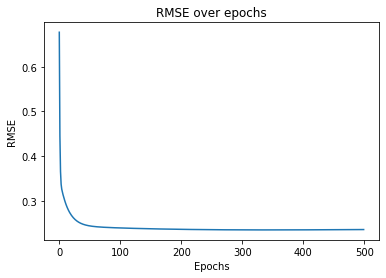

In [19]:
nn.loss_plot()

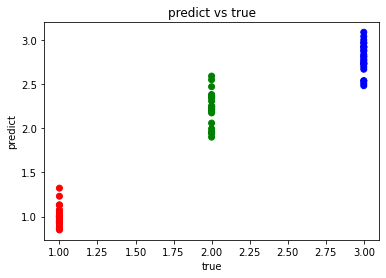

In [20]:
nn.predict_plot()